# Starfysh tutorial on a toy dataset

### Azizi Lab

Siyu He, Yinuo Jin

This is a tutorial on a simple simulated ST data generated from single cell RNA

10-31-2022

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip3 install scanpy
    #!pip3 install histomicstk
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    sys.path.append('/content/drive/MyDrive/SpatialModelProject/model_test_colab/')

In [2]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib.pyplot import rc_context

In [3]:
import matplotlib.font_manager
from matplotlib import rcParams

font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'

rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
                 
# Mute warning, TODO: manually fix the adata warnings (mostly due to "modification on copy" or version 
import warnings
warnings.filterwarnings('ignore')

## Load starfysh

In [4]:
from starfysh import (utils,
                      plot_utils,
                      starfysh,
                      dataloader,
                      post_analysis,
                      AA
                      )

### (1). load data and marker genes:
#### File Input: 
##### $\bullet$ spatial transcriptomics 
##### $\bullet$ gene signature for potential cell types

Starfysh is built on scanpy and anndata, two of the only imported files are just the data folder with count file and spatial information as provided by Visium platform.  

for example:

./data

    |-- simulated_ST_data_1

        |-- filtered_feature_bc_mactrix.h5
 
            |-- spatial

                  |-- aligned_fiducials.jpg
      
                  |-- detected_tissue_image.jpg
      
                  |-- scalefactors_json.json
      
                  |-- tissue_hires_image.png
      
                  |-- tissue_lowres_image.png
      
                  |-- tissue_positions_list.csv

    |-- simulated_ST_data_2

        |-- filtered_feature_bc_mactrix.h5
 
            |-- spatial

                  |-- aligned_fiducials.jpg
      
                  |-- detected_tissue_image.jpg
      
                  ...
                  
      
For those the data were not produced as traditional visium data structure, just construct the data as anndata structure as we showed here below for the simulated data as an example

In [5]:
ls

Starfysh tutorial on a toy dataset-Copy1.ipynb
slideseq_starfysh_tutorial_on_later.ipynb


In [6]:
adata_sample, adata_sample_normed = utils.load_adata(data_folder = '../data',
                                                     sample_id = 'simulated_ST_data_1',
                                                     n_genes=2000)


[2022-10-31 20:01:06] Preprocessing1: delete the mt and rp
Trying to set attribute `.var` of view, copying.
[2022-10-31 20:01:07] Preprocessing2: Normalize
[2022-10-31 20:01:07] Preprocessing3: Logarithm
[2022-10-31 20:01:08] Preprocessing4: Find the variable genes
Trying to set attribute `.var` of view, copying.


In [7]:
gene_sig = pd.read_csv(os.path.join('../data','tnbc_signature.csv'),index_col=0)
## filter the low expressed genes
gene_sig = utils.filter_gene_sig(gene_sig,adata_sample.to_df())

In [8]:
gene_sig.head()

,CAFs,Cancer Epithelial,Myeloid,Normal Epithelial,T-cells
0,DCN,SCGB2A2,C1QB,KRT14,CCL5
1,COL1A1,CD24,LYZ,KRT17,IL7R
2,LUM,MUCL1,C1QA,LTF,GNLY
3,COL1A2,KRT19,C1QC,KRT15,NKG7
4,SFRP2,SCGB1D2,TYROBP,PTN,CD3E


### (2). Preprocessing (finding anchor spots) 
##### $\bullet$ identify spot location 
for simulated data without spatial information, we are using the umap location instead

In [9]:
adata_sample

AnnData object with n_obs × n_vars = 2551 × 7704
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable'

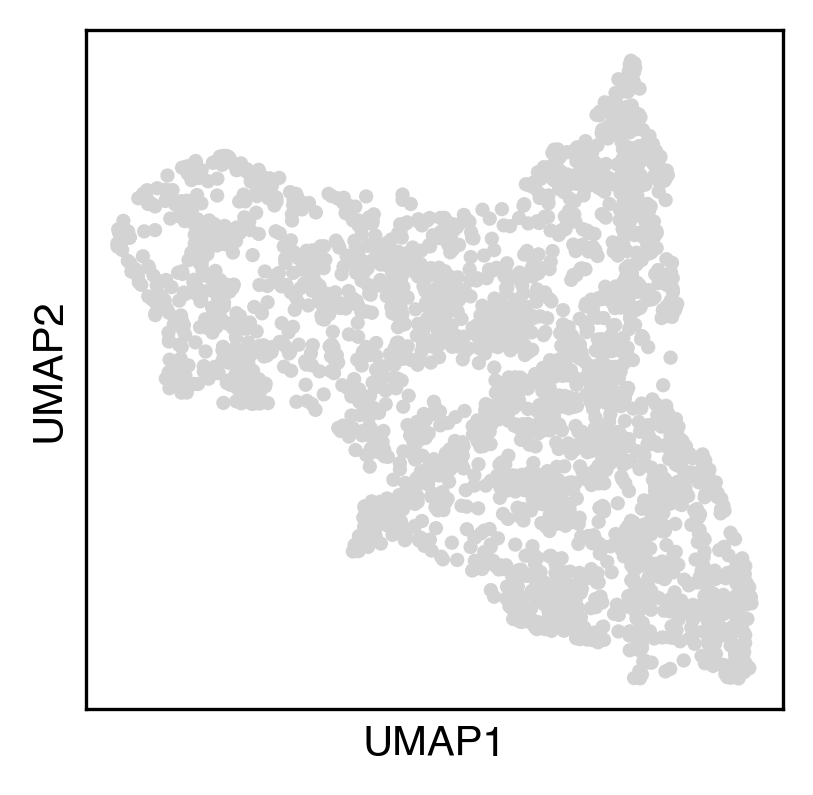

In [10]:
umap_df = utils.get_umap(adata_sample,display=True)
map_info = utils.get_simu_map_info(umap_df)

##### $\bullet$ Preparing arguments for model training


- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)

In [11]:
# Preparing arguments for model training
visium_args = utils.VisiumArguments(adata_sample,
                                    adata_sample_normed,
                                    gene_sig,
                                    map_info,
                                    n_anchors=60,
                                    window_size=3
                                   )

[2022-10-31 20:01:15] Filtering signatures not highly variable...
[2022-10-31 20:01:15] Smoothing library size by taking averaging with neighbor spots...


	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (146,)
	 After filter out some genes in the signature not in the var_names ... (143,)
	 After filter out some genes not highly expressed in the signature ... (143,)
	 Combine the varibale and siganture, the total unique gene number is ... 2008
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (146,)
	 After filter out some genes in the signature not in the var_names ... (143,)
	 After filter out some genes not highly expressed in the signature ... (143,)
	 Combine the varibale and siganture, the total unique gene number is ... 2008


[2022-10-31 20:01:16] Retrieving & normalizing signature gene expressions...
[2022-10-31 20:01:17] Identifying anchor spots (highly expression of specific cell-type signatures)...


##### $\bullet$ visuliaze the spatial raw data 

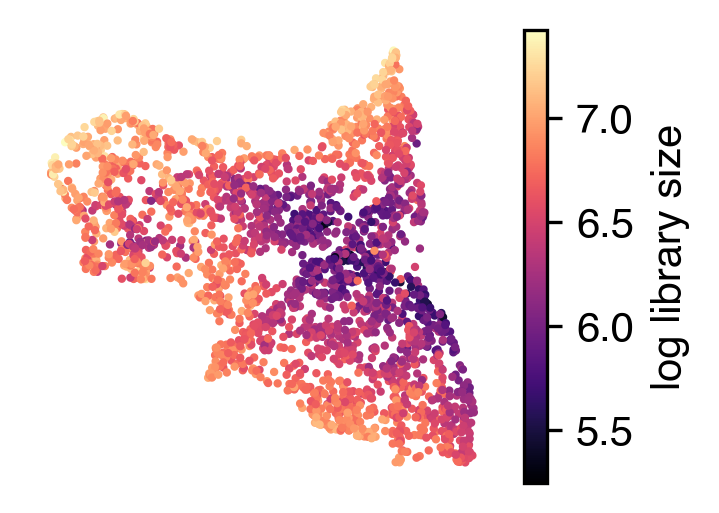

In [12]:
plot_utils.plot_spatial_feature(adata_sample,
                     map_info,
                     visium_args.log_lib,
                     label='log library size'
                           )

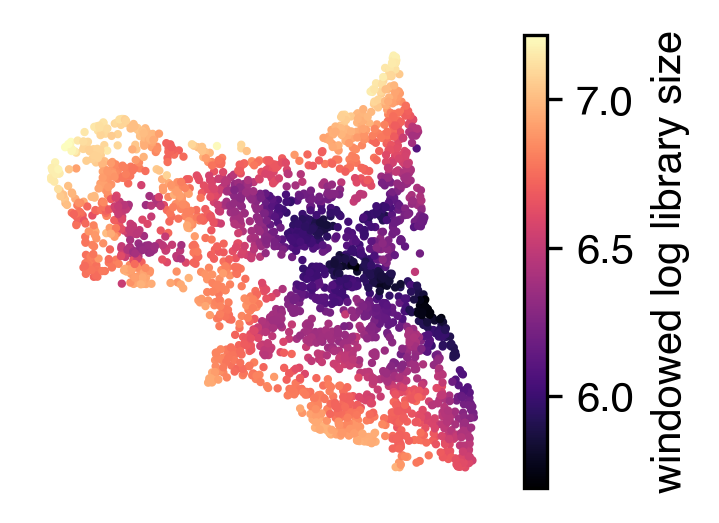

In [13]:
plot_utils.plot_spatial_feature(adata_sample,
                     map_info,
                     visium_args.win_loglib,
                     label='windowed log library size',
                )

plot raw gene expression:

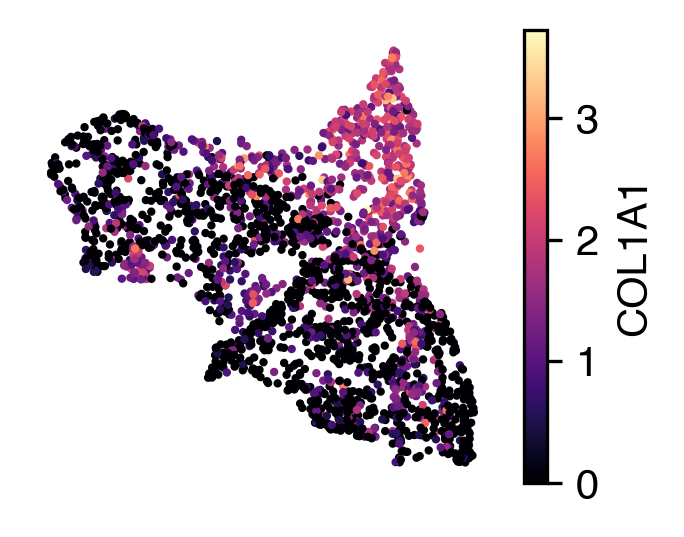

In [14]:
plot_utils.plot_spatial_gene(
                 adata_sample_normed,
                 map_info,
                 gene_name='COL1A1'
                )

##### $\bullet$ visuliaze anchor spots

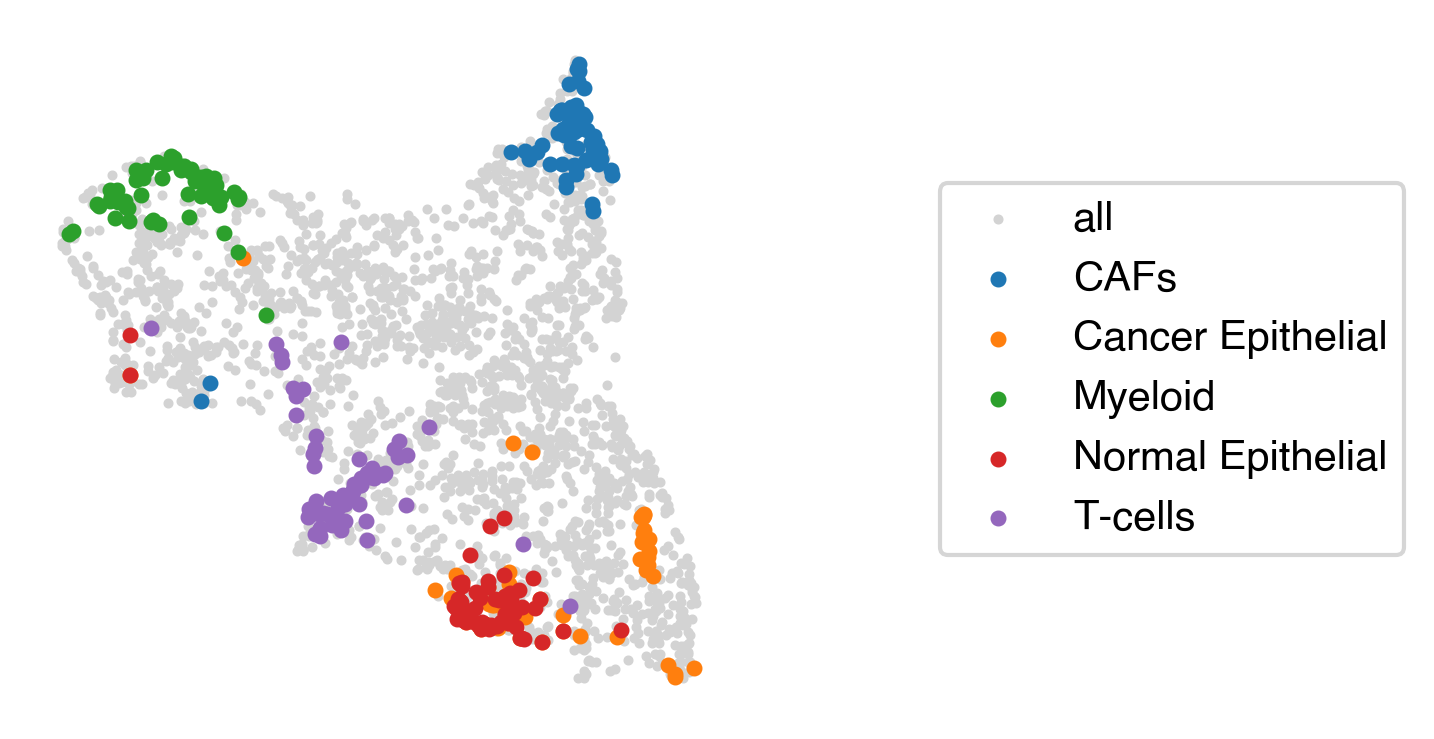

In [15]:
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

### (3). Optional: appending anchor spots with archetypal analysis

Tasks:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Find novel cell type / cell states as the most distant archetypes (Not close to any anchor spots of annotated cell types)

In [17]:
from _starfysh.AA import ArchetypalAnalysis

[Note]<br>
Set `pc_ratio` $(0, 1)$ higher to find more # raw archetypes ($k$). If you encounter `NaN` errors when estimating $k$, please decrease `pc_ratio`.

First, we find major archetypal spots & marker genes:

In [18]:
aa_model = ArchetypalAnalysis(adata_orig=adata_sample_normed)
archetype, arche_dict, major_idx = aa_model.compute_archetypes(pc_ratio=0.01, 
                                                               display=False)

[2022-10-31 20:01:32] Computing intrnsic dimension to estimate k...


33 components are retained using conditional_number=77.00


[2022-10-31 20:01:37] Computing 10 archetypes...
[2022-10-31 20:05:37] Calculating UMAPs for counts + Archetypes...
[2022-10-31 20:05:56] 0.8141 variance explained by raw archetypes.
Merging those within 20 NNs to get major archetypes


In [19]:
adata_sample, adata_sample_normed = visium_args.get_adata() # adata after preprocessing & taking highly-variable genes
anchors_df = visium_args.get_anchors() # anchor spot indices
anchors_df.head()

,CAFs,Cancer Epithelial,Myeloid,Normal Epithelial,T-cells
0,398,325,52,2495,757
1,321,950,509,1544,980
2,1614,1877,2213,2287,1743
3,1962,1683,1276,396,2501
4,1371,530,2343,946,1240


In [20]:
# Find archetypal spots, major specifies whether find hierarchical archetypes
arche_df = aa_model.find_archetypal_spots(major=False)

# Find marker genes
markers_df = aa_model.find_markers(n_markers=30, display=False)

# Map archetypes to closest anchors (1-1 per cell type) 
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=5)

[2022-10-31 20:05:57] Finding 40 nearest neighbors for each archetype...
[2022-10-31 20:06:00] Finding 30 top marker genes for each archetype...


In [21]:
aa_model.arche_dict

{1: array([1, 2, 4]), 3: array([3, 7]), 5: array([5, 9])}

In [22]:
map_dict

{'CAFs': 'arch_0',
 'Cancer Epithelial': 'arch_2',
 'Myeloid': 'arch_5',
 'Normal Epithelial': 'arch_2',
 'T-cells': 'arch_6'}

##### $\bullet$ visuliaze archetypes

(<Figure size 1800x1200 with 1 Axes>, <Axes3DSubplot:>)

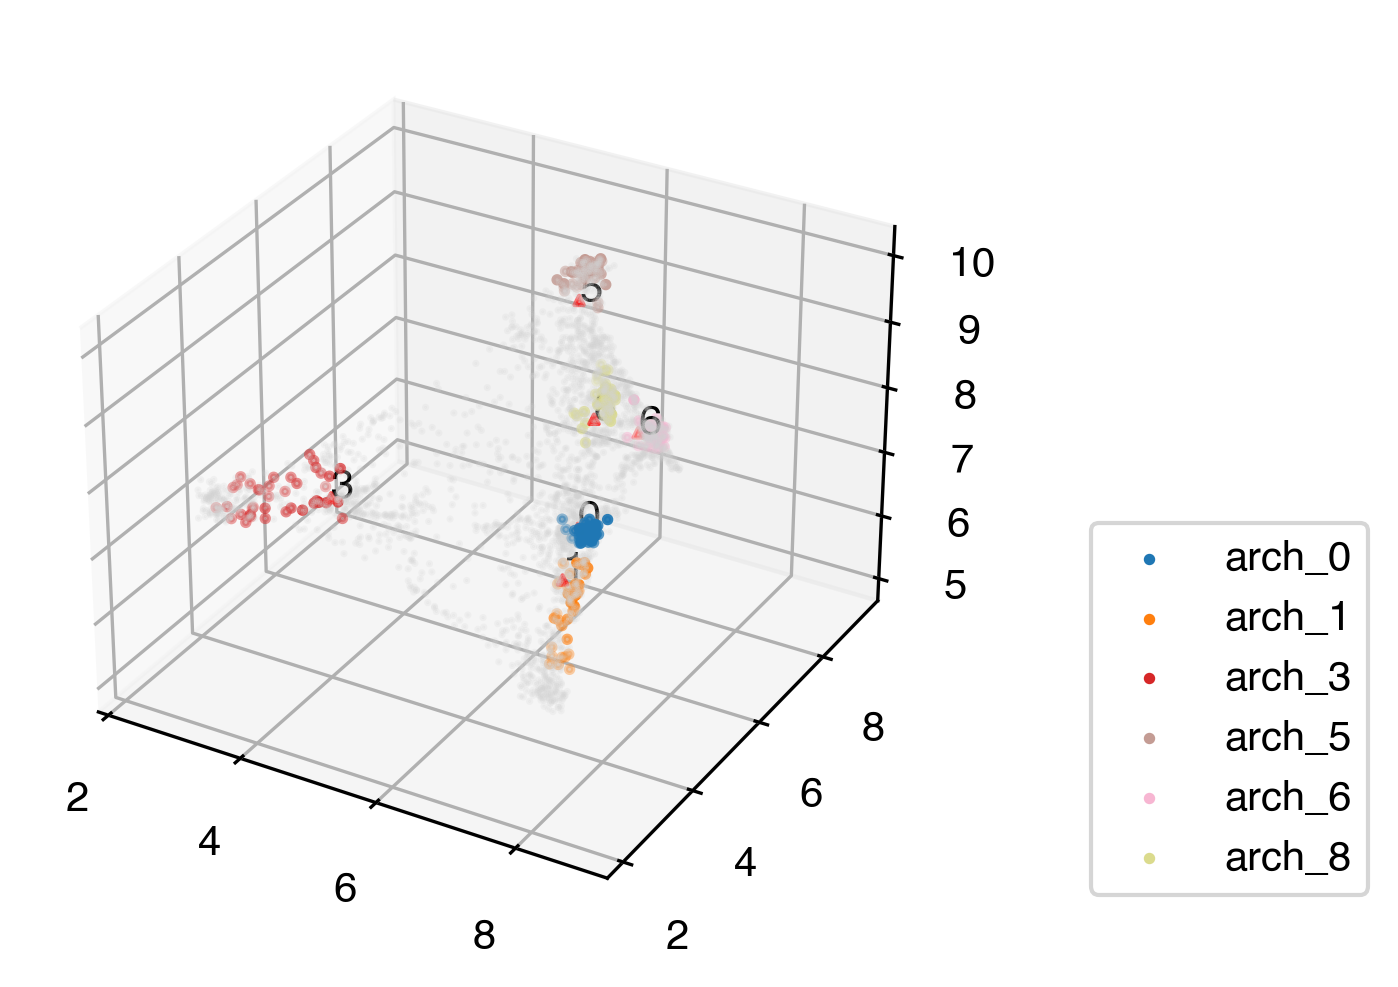

In [23]:
aa_model.plot_archetypes(do_3d=True)

##### $\bullet$ visualize overlapping ratio between archetypal & anchor spots:

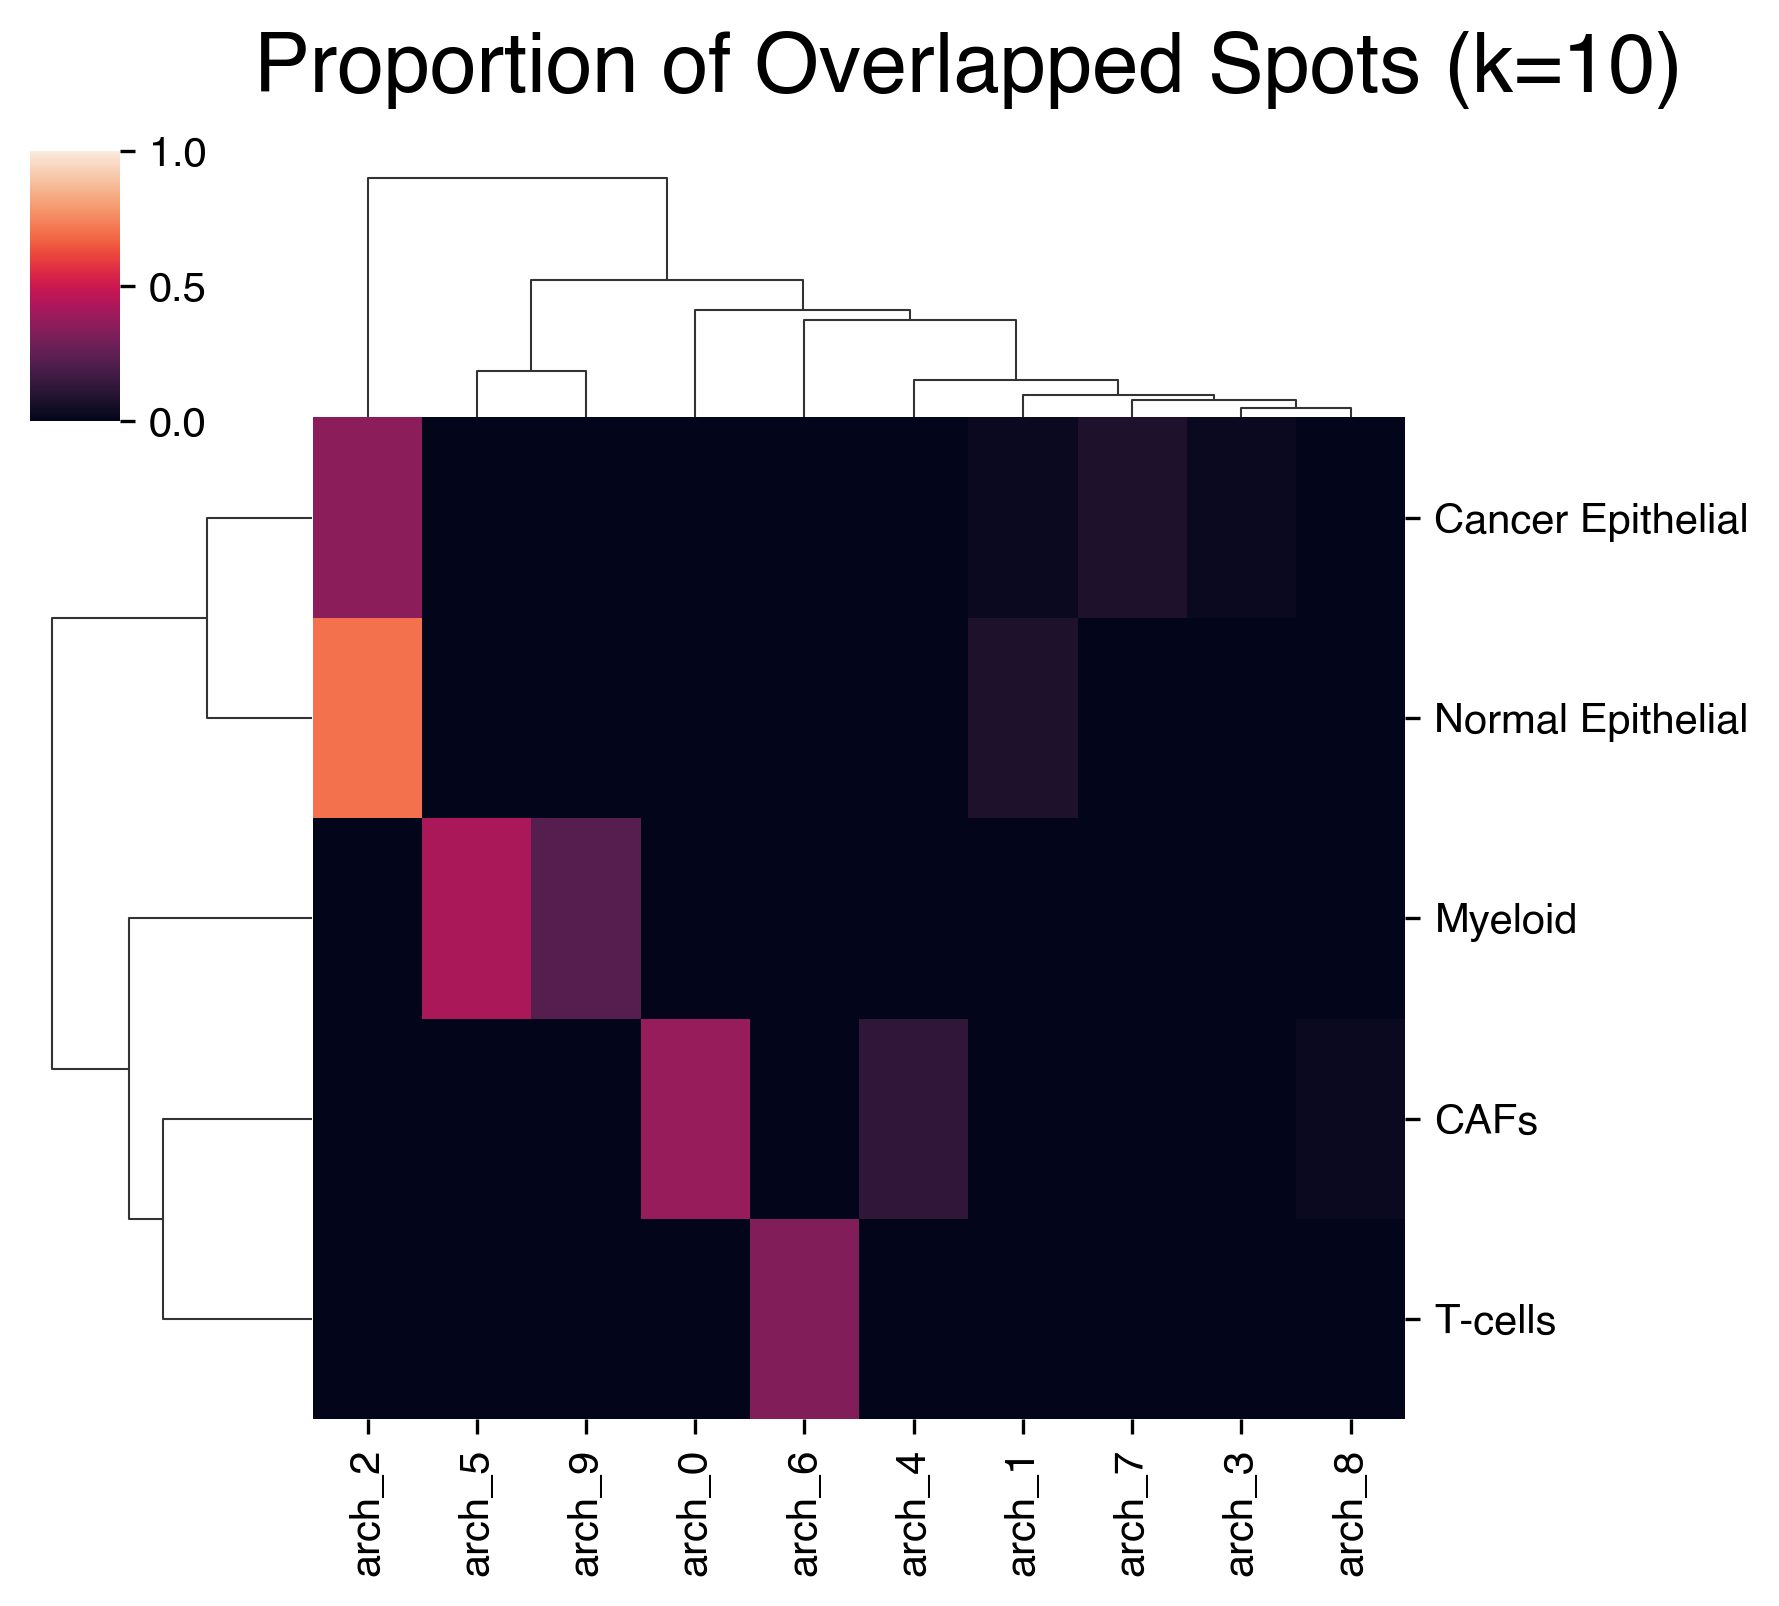

In [24]:
aa_model.plot_mapping(map_df)

##### Application: appending marker genes 
Find a factor with few annotated marker genes, find the archetype(s) having high overlapping ratio with it & append archetypal marker genes to the annotated marker genes.

E.g. T-cells: there'are only 30 signature which may lost some significant unique genes for this cell type. 

Assum every major cell type should have an archetype, thus first identifying the best archetypes for each cell type (also have warning to those if the map score is too low)

Manually/automated assign the anchor and archetypes

In [25]:
map_df

,arch_0,arch_1,arch_2,arch_3,arch_4,arch_5,arch_6,arch_7,arch_8,arch_9
CAFs,0.375,0.000,0.00,0.000,0.125,0.000,0.000,0.000,0.025,0.000
Cancer Epithelial,0.000,0.025,0.35,0.025,0.000,0.000,0.000,0.075,0.000,0.000
Myeloid,0.000,0.000,0.00,0.000,0.000,0.425,0.000,0.000,0.000,0.225
Normal Epithelial,0.000,0.075,0.70,0.000,0.000,0.000,0.000,0.000,0.000,0.000
T-cells,0.000,0.000,0.00,0.000,0.000,0.000,0.325,0.000,0.000,0.000


In [26]:
gene_sig.apply(
    lambda cell_type: 
    (~pd.isna(cell_type)).sum()
)

CAFs                 30
Cancer Epithelial    30
Myeloid              30
Normal Epithelial    30
T-cells              30
dtype: int64

In [27]:
map_used = map_df
gene_sig_add_archetypes = gene_sig.copy()
thre = 0.4
for i in range(gene_sig_add_archetypes.shape[1]):
        selected_arch = map_used.columns[map_used.loc[map_used.index[i],:]>=thre] #map_raw_df.columns[map_raw_df.loc[map_raw_df.index[i],:]>np.quantile(map_raw_df.loc[map_raw_df.index[i],:],0.8)]
        n_genes = 20
        #int(map_used.loc[map_used.index[i],selected_arch] * 30)
        for j in selected_arch:
            if map_used.loc[map_used.index[i],j]>=thre:
                print('appending', str(n_genes),
                      ' genes in ',
                      j,' to', map_used.index[i])
                gene_sig_add_archetypes = utils.append_sigs(
                        gene_sig=gene_sig, 
                        factor=map_used.index[i], 
                        sigs=map_used[j],
                        n_genes= n_genes
                    )

appending 20  genes in  arch_5  to Myeloid
appending 20  genes in  arch_2  to Normal Epithelial


In [28]:
gene_sig_add_archetypes = utils.append_sigs(
    gene_sig=gene_sig_add_archetypes,
    factor='Cancer Epithelial',
    sigs=markers_df['arch_7'],
    n_genes=20
)

In [29]:
gene_sig_add_archetypes.apply(
    lambda cell_type: 
    (~pd.isna(cell_type)).sum()
)

CAFs                 30
Cancer Epithelial    49
Myeloid              30
Normal Epithelial    33
T-cells              30
dtype: int64

## Run starfysh

We restart the model for `n_repeat` times, select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

### (1). Model parameters

In [30]:
n_repeats = 3
epochs = 100
patience = 10
device = torch.device('cpu')

### (2). Model training

In [31]:
# update arguments
visium_args = utils.VisiumArguments(adata_sample,
                                    adata_sample_normed,
                                    gene_sig_add_archetypes,
                                    map_info,
                                    n_anchors=60,
                                    window_size=3
                                   )


[2022-10-31 20:06:25] Filtering signatures not highly variable...


	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (169,)
	 After filter out some genes in the signature not in the var_names ... (152,)
	 After filter out some genes not highly expressed in the signature ... (152,)
	 Combine the varibale and siganture, the total unique gene number is ... 2008
	 The number of original variable genes in the dataset (2000,)
	 The number of siganture genes in the dataset (169,)
	 After filter out some genes in the signature not in the var_names ... (152,)


[2022-10-31 20:06:25] Smoothing library size by taking averaging with neighbor spots...


	 After filter out some genes not highly expressed in the signature ... (152,)
	 Combine the varibale and siganture, the total unique gene number is ... 2008


[2022-10-31 20:06:26] Retrieving & normalizing signature gene expressions...
[2022-10-31 20:06:27] Identifying anchor spots (highly expression of specific cell-type signatures)...


In [32]:
# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 patience=patience,
                                 device=device
                                )

[2022-10-31 20:06:27] Running Starfysh with 3 restarts, choose the model with best parameters...
[2022-10-31 20:06:27]  ===  Restart Starfysh 1 === 

[2022-10-31 20:06:27] Initializing model parameters...
[2022-10-31 20:06:59] Epoch[10/100], train_loss: 659.8201, train_reconst: 515.8882, train_z: 18.3134,train_c: 101.4788,train_n: 24.1397
[2022-10-31 20:07:29] Epoch[20/100], train_loss: 610.2655, train_reconst: 484.9448, train_z: 18.2489,train_c: 83.5863,train_n: 23.4855
[2022-10-31 20:08:01] Epoch[30/100], train_loss: 583.4242, train_reconst: 466.5735, train_z: 18.6138,train_c: 74.9653,train_n: 23.2717
[2022-10-31 20:08:32] Epoch[40/100], train_loss: 563.0180, train_reconst: 453.6835, train_z: 18.5904,train_c: 67.8131,train_n: 22.9311
[2022-10-31 20:09:03] Epoch[50/100], train_loss: 554.2118, train_reconst: 444.9541, train_z: 18.9930,train_c: 67.6270,train_n: 22.6378
[2022-10-31 20:09:35] Epoch[60/100], train_loss: 540.2355, train_reconst: 438.2406, train_z: 19.0935,train_c: 60.3113,t

## Basic downstream analysis

In [75]:
import importlib
importlib.reload(plot_utils)

<module '_starfysh.plot_utils' from '/Users/siyuhe/Documents/GitHub/starfysh/notebooks/../_starfysh/plot_utils.py'>

### (1) Extract the inferred parameter from starfysh

#### $\bullet$ get 2D visualization of inferred latent sapce

In [35]:
lib_low=torch.exp(torch.Tensor([5.0])).to(device)

inference_outputs, generative_outputs, px = starfysh.model_eval(model,
                                                                adata_sample, 
                                                                visium_args.sig_mean,
                                                                device,
                                                                visium_args.log_lib,
                                                                lib_low
                                                               )
u = post_analysis.get_z_umap(inference_outputs,map_info)
u = pd.DataFrame(u,columns=['umap1','umap2'])
u.index = map_info.index

#### $\bullet$ get cell type specific gene expression

In [36]:
px_0 = starfysh.model_ct_exp(model,
                             adata_sample, 
                             visium_args.sig_mean, 
                             device,
                             visium_args.log_lib,
                             lib_low,
                             ct_idx=0)

### (2) Visualize the starfysh results

#### $\bullet$ gene sig mean vs. inferred prop

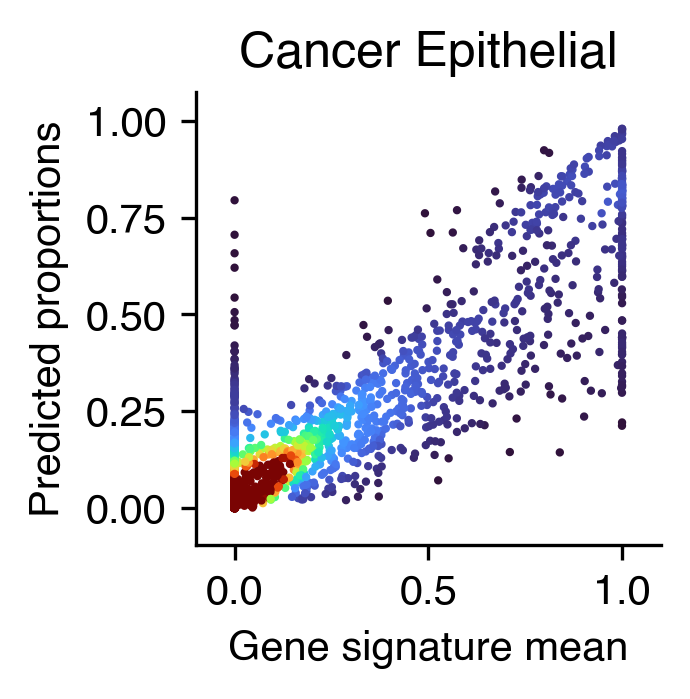

In [37]:
post_analysis.gene_mean_vs_inferred_prop(inference_outputs,
                                         visium_args,
                                         idx=1 ## the order of the cell types
                               )

#### $\bullet$ compare the data with ground truth proportion for this simulated data

In [38]:
member = pd.read_csv(os.path.join('../data','simulated_ST_data_1','members.st_synth.csv'),index_col=0)
proportions = pd.read_csv(os.path.join('../data','simulated_ST_data_1','proportions.st_synth.csv'),index_col=0)

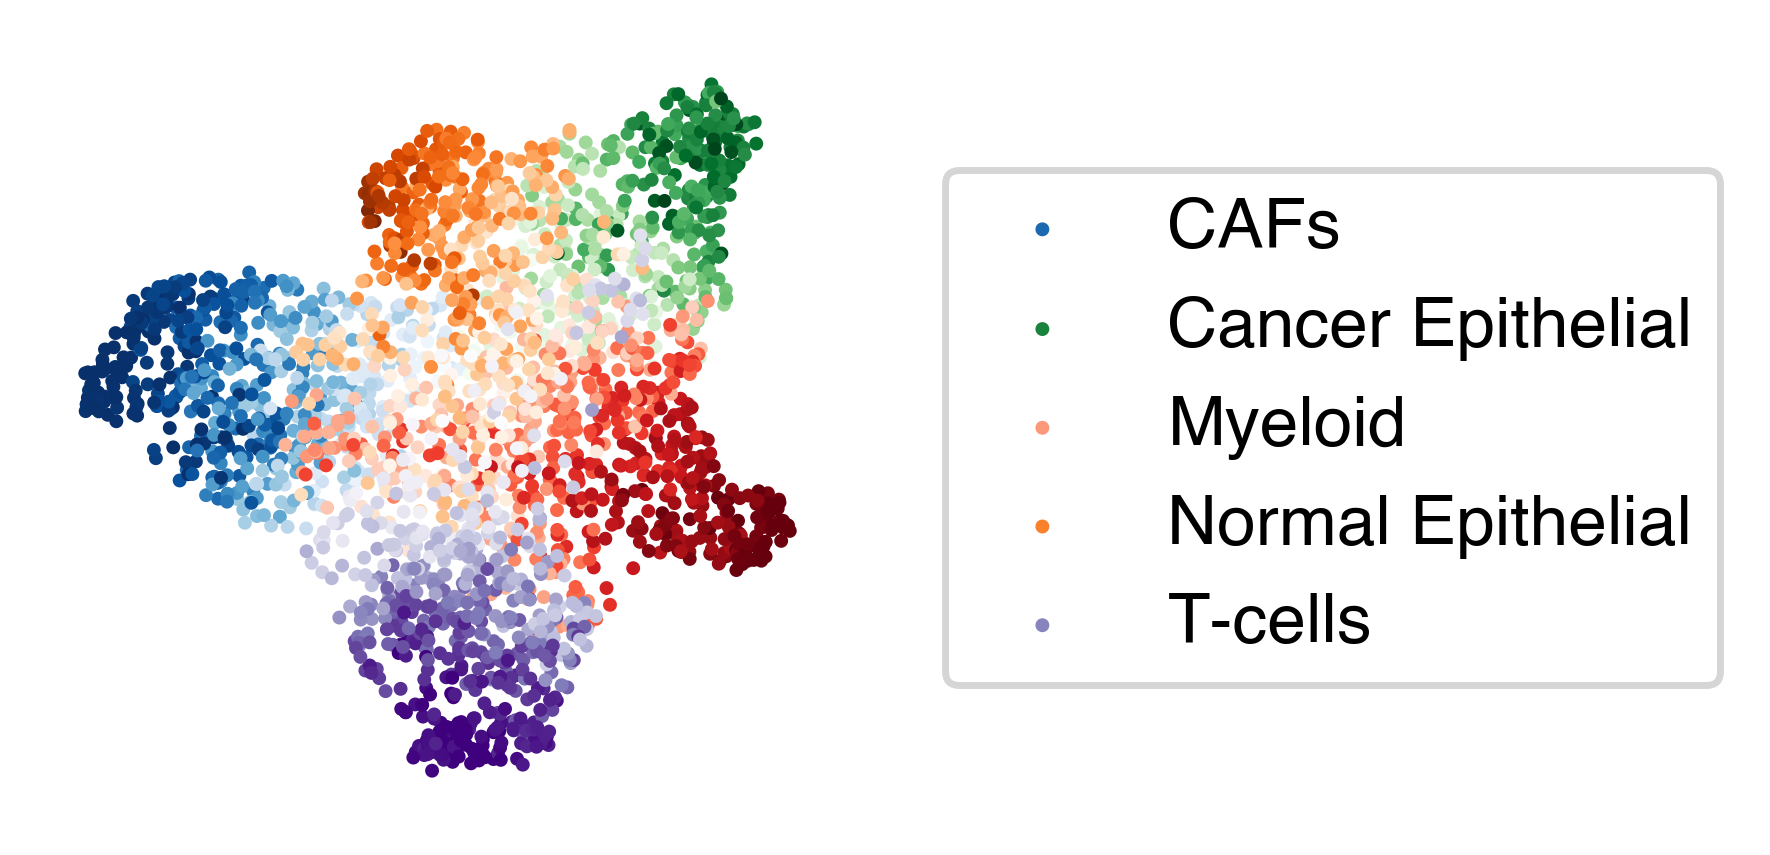

In [39]:
post_analysis.plot_type_all(inference_outputs,np.array(u),proportions)

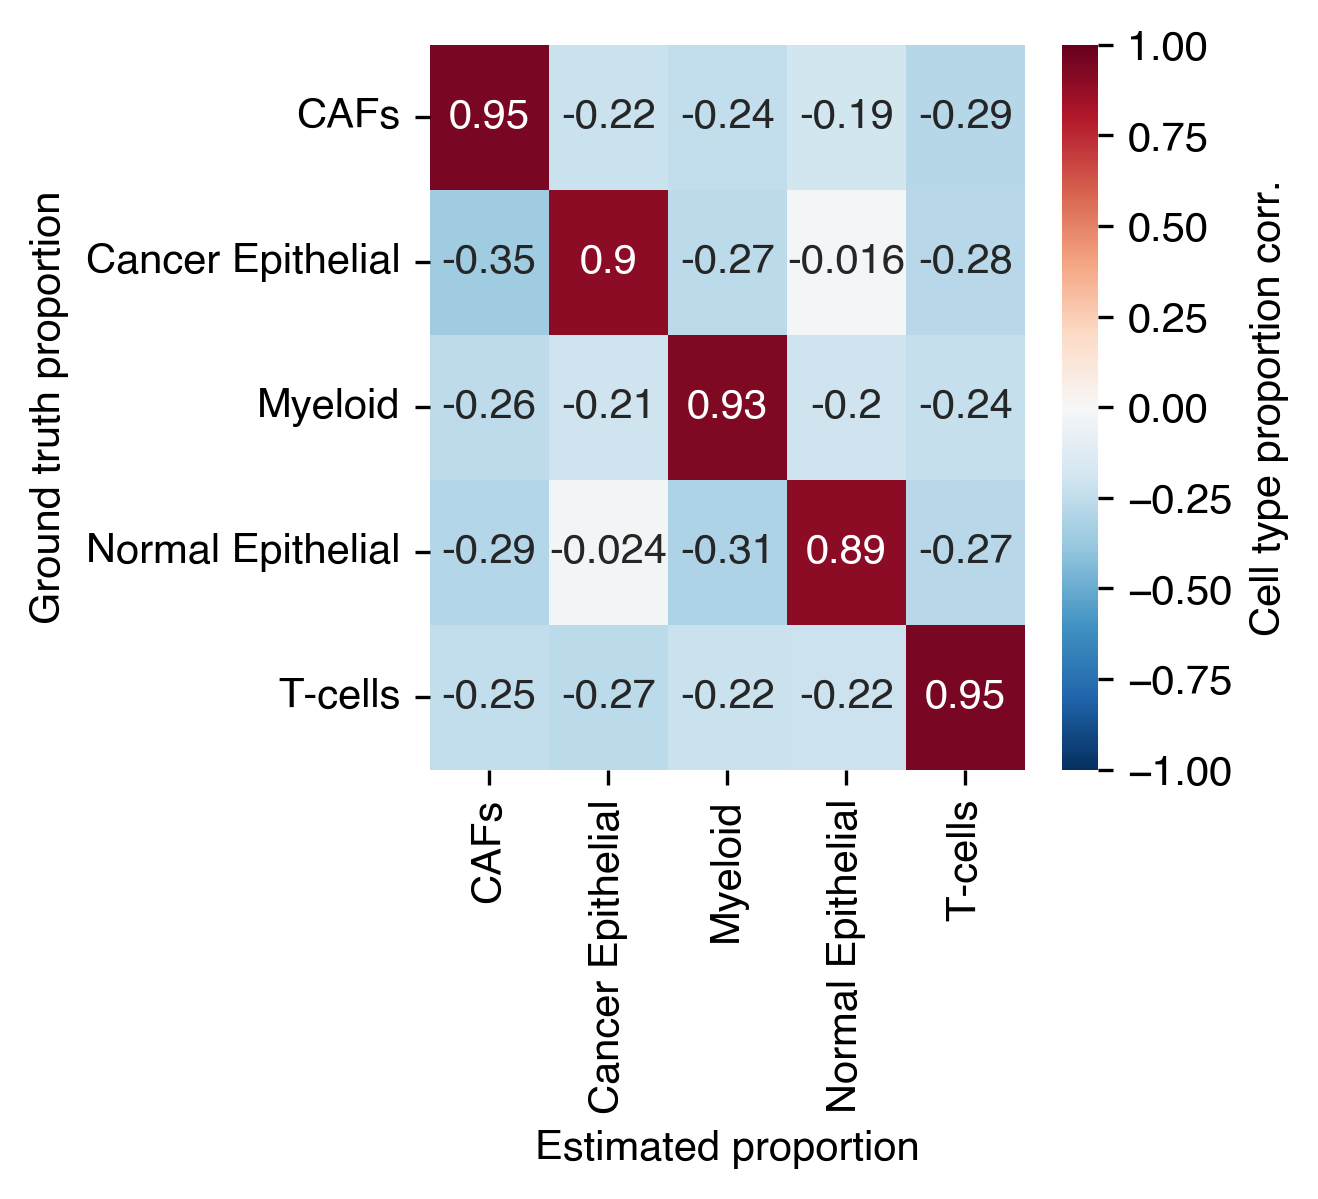

In [46]:
post_analysis.get_corr_map(inference_outputs,proportions)

#### $\bullet$ inferred density

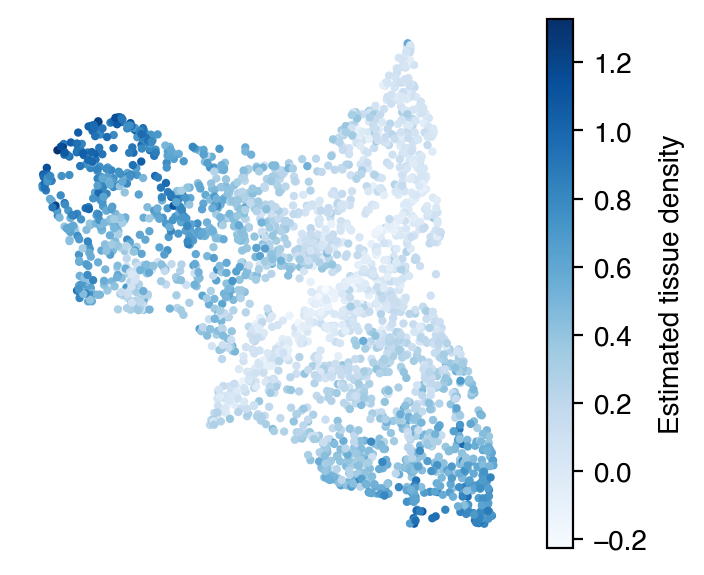

In [56]:
plot_utils.pl_spatial_inf_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='ql_m',
                   idx=0,
                   plt_title='',
                   label='Estimated tissue density',
                   s=4,
                   cmap='Blues'
                   #vmax=3
                   )

#### $\bullet$ inferred prop. (adjust idx number for different cell types)

Cell-type: `Cancer epithelial`

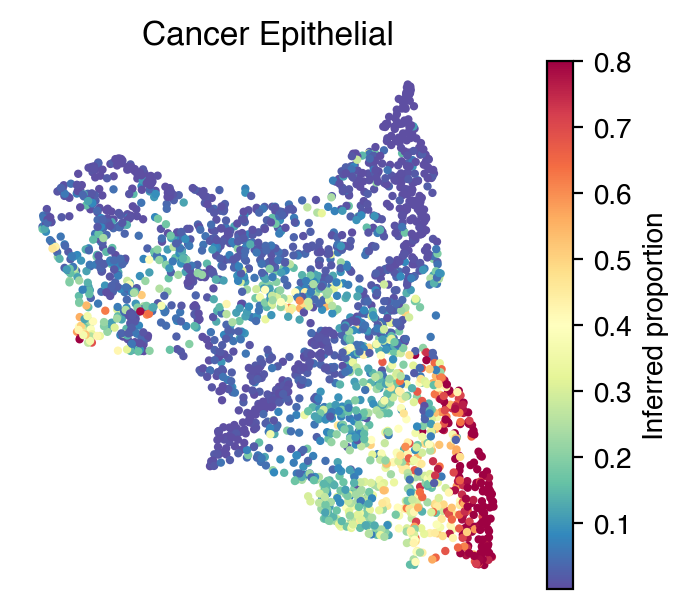

In [59]:
idx=1
plot_utils.pl_spatial_inf_feature(adata_sample,
                   map_info,
                   inference_outputs,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8
                   )

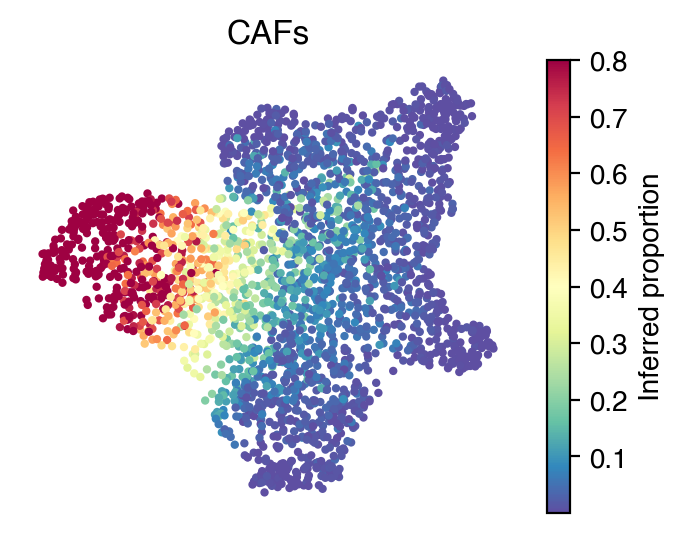

In [66]:
idx=0

plot_utils.pl_umap_feature(adata_sample,
                   u,
                   inference_outputs,
                   feature='qc_m',
                   idx=idx,
                   plt_title=gene_sig.columns[idx],
                   label='Inferred proportion',
                   s=4,
                   vmax=0.8)


#### $\bullet$ Inferred cell-type specific expressions for each spots

In [67]:
pred_exp = {}
for i, label in enumerate(gene_sig.columns):
    pred_exp[label] = starfysh.model_ct_exp(model,adata_sample, 
                                            visium_args.sig_mean_znorm, 
                                            device,
                                            visium_args.log_lib,
                                            lib_low,
                                            ct_idx=i
                                           ).tolist()

In [72]:
pred_exp.keys()

dict_keys(['CAFs', 'Cancer Epithelial', 'Myeloid', 'Normal Epithelial', 'T-cells'])

View of AnnData object with n_obs × n_vars = 2551 × 2008
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'highly_variable'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Plot spot-level expression of `PDCD1` from *CD8 T cell activation*:

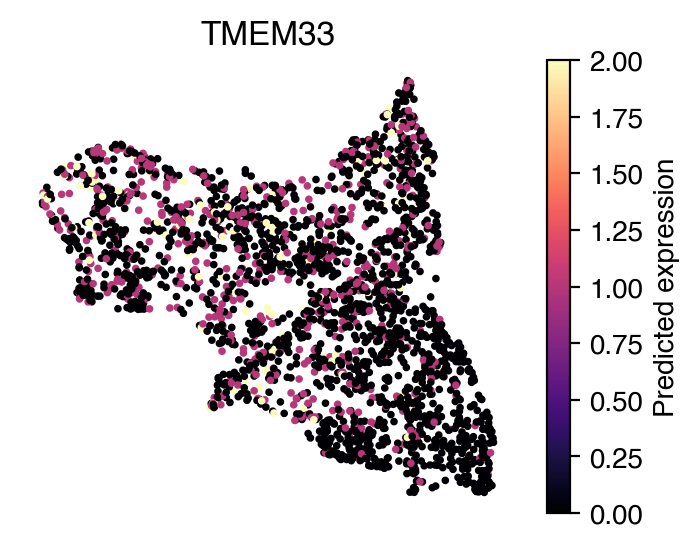

In [86]:
from scipy import stats

"""
px_0 = starfysh.model_ct_exp(model,adata_sample, 
                             sig_mean, device,log_lib,lib_low,
                             ct_idx=13
                            )
idx=list(adata_sample.var_names).index('PDCD1')
"""
idx = list(adata_sample.var_names[adata_sample.var['highly_variable']]).index('TMEM33')
plot_utils.pl_spatial_inf_gene(adata_sample,
                   map_info,
                   feature=np.asarray(pred_exp['Cancer Epithelial']),
                   idx= idx,
                   plt_title=list(adata_sample.var_names[adata_sample.var['highly_variable']])[idx],
                   label='Predicted expression',
                   s=3,
                   vmax=2)